In [2]:
%load_ext autoreload
%autoreload 2

import os 
os.chdir('/workspaces/anaconda/transformer_arithmetic')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from lib.config import config
from transformer_lens import HookedTransformer
from lib.train import init_model, evaluate
from lib.utils.addition_utils import detect_carry
from lib.data import get_train_test_loaders
import torch as t

override_config = {}
override_config['ckpt_name'] = 'ckpt_12750.pt'
override_config['out_dir'] = f'out/tiny_models/reverse-n_digit-3-n_embd-48-n_layer-1-n_head-3'
override_config['resume'] = True
override_config['wandb_log'] = False
override_config['device'] = 'cuda:0'
override_config['num_test'] = 1000
override_config['use_hookedtransformer'] = True
override_config['use_saved_config'] = True
override_config['dataset'] = 'addition'
model, it, best_val_acc, ckpt, encode, decode, vocab_size = init_model(config, override_config=override_config)
model: HookedTransformer
model.eval()
print(it, config['n_digit'])
train_dataloader, test_dataloaders, test_train_dataloader = get_train_test_loaders(encode, config)
# test_dataloaders[0].dataset.prompt_pad_length = 30
test_dataloader = test_dataloaders[0]
evaluate(model, it, [test_dataloader], encode, decode, config=config, verbose=True)
tds = [d for d in test_dataloader.dataset]
test_dataset = test_dataloader.collate_fn(tds)
carries = t.tensor([sum([c[i]*2**i for i in range(len(c))]) for c in test_dataset['carries'].cpu().numpy()])
eq_pos = test_dataloader.dataset.prompt_pad_length - 1
pad_token_id = test_dataloader.dataset.pad_token_id


all the unique characters: 
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~
vocab size: 96
12750 3


100%|██████████| 1/1 [00:04<00:00,  4.41s/it]

inp: '##$799+2=' out: '009$' ans: '108$'
inp: '#$710+49=' out: '958$' ans: '957$'
inp: '$355+119=' out: '464$' ans: '474$'
inp: '#$890+34=' out: '439$' ans: '429$'
inp: '#$408+88=' out: '684$' ans: '694$'
inp: '#$913+73=' out: '699$' ans: '689$'
inp: '#$396+90=' out: '683$' ans: '684$'
inp: '##$481+3=' out: '191$' ans: '484$'
inp: '##$975+7=' out: '198$' ans: '289$'
inp: '#$793+20=' out: '328$' ans: '318$'
inp: '##$2+639=' out: '149$' ans: '146$'
inp: '##$883+5=' out: '399$' ans: '888$'
inp: '##$846+8=' out: '158$' ans: '458$'
inp: '##$986+5=' out: '499$' ans: '199$'
inp: '###$66+4=' out: '92=45$' ans: '07$'
inp: '##$7+998=' out: '608$' ans: '5001$'
inp: '#$982+78=' out: '069$' ans: '0601$'
inp: '#$27+904=' out: '130$' ans: '139$'
inp: '##$29+81=' out: '091$' ans: '011$'
inp: '##$895+9=' out: '897$' ans: '409$'
inp: '##$961+4=' out: '079$' ans: '569$'
inp: '###$61+6=' out: '96$' ans: '76$'
inp: '##$24+81=' out: '391$' ans: '501$'
inp: '##$1+169=' out: '079$' ans: '071$'
inp: '#$65+390=

In [3]:
model.process_weights_()


7
[[6 6 6]]


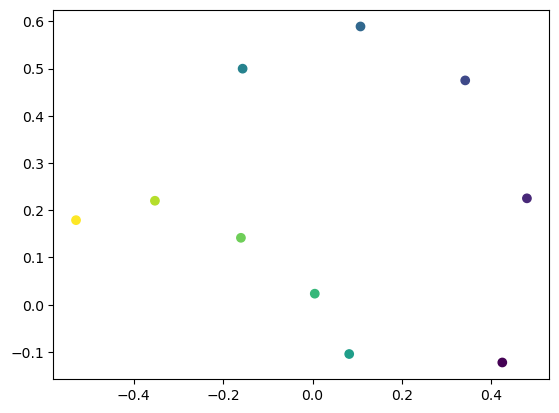

In [54]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np

pca = PCA()

digits = model.W_E[encode('0123456789')].detach().cpu().numpy()

rank = np.linalg.matrix_rank(digits, tol=0.01)
print(rank)

V_digits = digits @ model.W_V.detach().cpu().numpy()

layer = 0
head = 0

pca.fit(V_digits[layer, head].T)

plt.scatter(pca.components_[0], pca.components_[1], c=range(10))


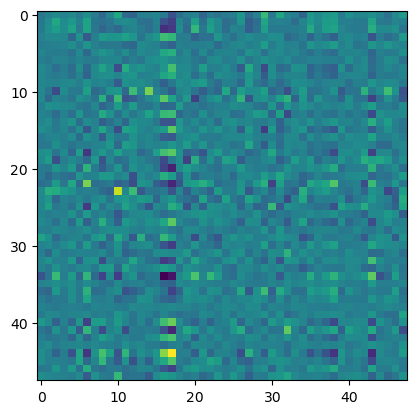

In [46]:
W_Q = model.W_Q.detach().cpu().numpy()
W_K = model.W_K.detach().cpu().numpy()

QK = np.einsum('lhij,lhkj->lhik', W_Q, W_K)

plt.imshow(QK[layer, head])
